<a href="https://colab.research.google.com/github/Latiefabdul/My_Project/blob/main/DS_Project_E_commerce_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering on e-commerce data

Kita memiliki suatu dataset dari University of California Irvine yang membahas tentang data online retail atau e-commerce (https://archive.ics.uci.edu/ml/datasets/online+retail). 

Di sini kita dapat melakukan pembelajaran tentang produk-produk yang menghasilkan revenue tertinggi.

Dari pembelajaran ini, harapannya kita dapat memberikan solusi yang tepat dalam memberikan keputusan bisnis tentang produk mana yang dapat kita tingkatkan

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'

Load dataset dengan pandas

In [ ]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')

In [ ]:
df.head(10)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
5 2010-12-01 08:26:00       7.65     17850.0  United Kingdom  
6 2010-12-01 08:26:00       4.25     17850.0  United Kingdom  
7 2010-12-01 08:28:00       1.85     17850.0  United Kingdom  
8 2010-12-01 08:28:00       1.85     17850.0  United Kingdom  
9 2010-12-01 08:34:00       1.69     13047.0  United Kingdom

### **Investigasi data**

In [ ]:
types = df.dtypes
distinct = df.nunique()
count_na = df.isna().sum()
percent_na = round((df.isna().sum()/len(df))*100, 3)

print('dimensi data: ', df.shape)

df_check = pd.concat([types, distinct, count_na, percent_na], axis=1)
df_check.reset_index(level=0, inplace=True)
df_check.rename(columns = {'index':'column', 0:'types', 1:'distinct', 2:'count_na', 3: 'percent_na'}, inplace = True)
df_check

dimensi data:  (541909, 8)


column           types  distinct  count_na  percent_na
0    InvoiceNo          object     25900         0       0.000
1    StockCode          object      4070         0       0.000
2  Description          object      4223      1454       0.268
3     Quantity           int64       722         0       0.000
4  InvoiceDate  datetime64[ns]     23260         0       0.000
5    UnitPrice         float64      1630         0       0.000
6   CustomerID         float64      4372    135080      24.927
7      Country          object        38         0       0.000

**Cleansing Data**

Terdapat 24.927 % data pada kolom CustomerID yang null, hal ini agak sulit untuk dilakukan imputasi karena missing value bukan bersifat konteks data pada konten, sehingga akan lebih baik jika kita hilangkan saja meskipun akan membuang 24.927 % data.

In [ ]:
data = df.dropna(axis = 0, subset = ['CustomerID'])

types = data.dtypes
distinct = data.nunique()
count_na = data.isna().sum()
percent_na = round((data.isna().sum()/len(data))*100, 3)

print('dimensi data: ', data.shape)

df_check = pd.concat([types, distinct, count_na, percent_na], axis=1)
df_check.reset_index(level=0, inplace=True)
df_check.rename(columns = {'index':'column', 0:'types', 1:'distinct', 2:'count_na', 3: 'percent_na'}, inplace = True)
df_check

dimensi data:  (406829, 8)


column           types  distinct  count_na  percent_na
0    InvoiceNo          object     22190         0         0.0
1    StockCode          object      3684         0         0.0
2  Description          object      3896         0         0.0
3     Quantity           int64       436         0         0.0
4  InvoiceDate  datetime64[ns]     20460         0         0.0
5    UnitPrice         float64       620         0         0.0
6   CustomerID         float64      4372         0         0.0
7      Country          object        37         0         0.0

Dengan melakukan drop untuk semua CustomerID yang null ternyata sekaligus melakukan drop 0.268 % data pada kolom Description yang null.

Selanjutnya kita cek berapa banyak data duplikat

In [ ]:
print('Data yang duplikat: {}'.format(data.duplicated().sum()))

data[data.duplicated(keep = False)].sort_values(['InvoiceNo', 'StockCode'])

Data yang duplikat: 5225


InvoiceNo StockCode                          Description  Quantity  \
494       536409     21866          UNION JACK FLAG LUGGAGE TAG         1   
517       536409     21866          UNION JACK FLAG LUGGAGE TAG         1   
485       536409     22111         SCOTTIE DOG HOT WATER BOTTLE         1   
539       536409     22111         SCOTTIE DOG HOT WATER BOTTLE         1   
489       536409     22866        HAND WARMER SCOTTY DOG DESIGN         1   
...          ...       ...                                  ...       ...   
440149   C574510     22360      GLASS JAR ENGLISH CONFECTIONERY        -1   
461407   C575940     23309  SET OF 60 I LOVE LONDON CAKE CASES        -24   
461408   C575940     23309  SET OF 60 I LOVE LONDON CAKE CASES        -24   
529980   C580764     22667                RECIPE BOX RETROSPOT        -12   
529981   C580764     22667                RECIPE BOX RETROSPOT        -12   

               InvoiceDate  UnitPrice  CustomerID         Country  
494    2010-12-01 11:45:00       1.25     17908.0  United Kingdom  
517    2010-12-01 11:45:00       1.25     17908.0  United Kingdom  
485    2010-12-01 11:45:00       4.95     17908.0  United Kingdom  
539    2010-12-01 11:45:00       4.95     17908.0  United Kingdom  
489    2010-12-01 11:45:00       2.10     17908.0  United Kingdom  
...                    ...        ...         ...             ...  
440149 2011-11-04 13:25:00       2.95     15110.0  United Kingdom  
461407 2011-11-13 11:38:00       0.55     17838.0  United Kingdom  
461408 2011-11-13 11:38:00       0.55     17838.0  United Kingdom  
529980 2011-12-06 10:38:00       2.95     14562.0  United Kingdom  
529981 2011-12-06 10:38:00       2.95     14562.0  United Kingdom  

[10062 rows x 8 columns]

Kita dapat meringkas data duplikat ini menjadi unique di tiap row, dan cek kembali apakah masih ada data yang duplikat

In [ ]:
data.drop_duplicates(inplace = True)

print('Data yang duplikat: {}'.format(data.duplicated().sum()))
data[data.duplicated(keep = False)].sort_values(['InvoiceNo', 'StockCode'])

data['StockCode'] = data['StockCode'].astype(str)
data['CustomerID'] = data['CustomerID'].astype(int)
data['CustomerID'] = data['CustomerID'].astype(str)

print(len(data))

Data yang duplikat: 0
401604


In [ ]:
# select numeric columns
data.select_dtypes(include=[np.number]).columns

Index(['Quantity', 'UnitPrice'], dtype='object')

In [ ]:
data.sort_values('Quantity')

InvoiceNo StockCode                          Description  Quantity  \
540422   C581484     23843          PAPER CRAFT , LITTLE BIRDIE    -80995   
61624    C541433     23166       MEDIUM CERAMIC TOP STORAGE JAR    -74215   
4287     C536757     84347  ROTATING SILVER ANGELS T-LIGHT HLDR     -9360   
160145   C550456     21108   FAIRY CAKE FLANNEL ASSORTED COLOUR     -3114   
160144   C550456     21175          GIN + TONIC DIET METAL SIGN     -2000   
...          ...       ...                                  ...       ...   
206121    554868     22197                 SMALL POPCORN HOLDER      4300   
421632    573008     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS      4800   
502122    578841     84826       ASSTD DESIGN 3D PAPER STICKERS     12540   
61619     541431     23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
540421    581483     23843          PAPER CRAFT , LITTLE BIRDIE     80995   

               InvoiceDate  UnitPrice CustomerID         Country  
540422 2011-12-09 09:27:00       2.08      16446  United Kingdom  
61624  2011-01-18 10:17:00       1.04      12346  United Kingdom  
4287   2010-12-02 14:23:00       0.03      15838  United Kingdom  
160145 2011-04-18 13:08:00       2.10      15749  United Kingdom  
160144 2011-04-18 13:08:00       1.85      15749  United Kingdom  
...                    ...        ...        ...             ...  
206121 2011-05-27 10:52:00       0.72      13135  United Kingdom  
421632 2011-10-27 12:26:00       0.21      12901  United Kingdom  
502122 2011-11-25 15:57:00       0.00      13256  United Kingdom  
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom  
540421 2011-12-09 09:15:00       2.08      16446  United Kingdom  

[401604 rows x 8 columns]

In [ ]:
data.sort_values('UnitPrice')

InvoiceNo StockCode                          Description  Quantity  \
379913    569716     22778                   GLASS CLOCHE SMALL         2   
446793    574920     22899         CHILDREN'S APRON DOLLY GIRL          1   
314745    564651     23270     SET OF 2 CERAMIC PAINTED HEARTS         96   
314746    564651     23268  SET OF 2 CERAMIC CHRISTMAS REINDEER       192   
314747    564651     22955             36 FOIL STAR CAKE CASES        144   
...          ...       ...                                  ...       ...   
268027   C560372         M                               Manual        -1   
173391   C551699         M                               Manual        -1   
173277   C551685      POST                              POSTAGE        -1   
173382    551697      POST                              POSTAGE         1   
222681   C556445         M                               Manual        -1   

               InvoiceDate  UnitPrice CustomerID         Country  
379913 2011-10-06 08:17:00       0.00      15804  United Kingdom  
446793 2011-11-07 16:34:00       0.00      13985  United Kingdom  
314745 2011-08-26 14:19:00       0.00      14646     Netherlands  
314746 2011-08-26 14:19:00       0.00      14646     Netherlands  
314747 2011-08-26 14:19:00       0.00      14646     Netherlands  
...                    ...        ...        ...             ...  
268027 2011-07-18 12:26:00    4287.63      17448  United Kingdom  
173391 2011-05-03 14:12:00    6930.00      16029  United Kingdom  
173277 2011-05-03 12:51:00    8142.75      16029  United Kingdom  
173382 2011-05-03 13:46:00    8142.75      16029  United Kingdom  
222681 2011-06-10 15:31:00   38970.00      15098  United Kingdom  

[401604 rows x 8 columns]

In [ ]:
# data['UnitPrice'].describe()

print(data.describe())

print(len(data[data['UnitPrice'] == 0]))

print(len(data[data['Quantity'] < 0]))

            Quantity      UnitPrice
count  401604.000000  401604.000000
mean       12.183273       3.474064
std       250.283037      69.764035
min    -80995.000000       0.000000
25%         2.000000       1.250000
50%         5.000000       1.950000
75%        12.000000       3.750000
max     80995.000000   38970.000000
40
8872


**Cleansing 0 UnitPrice**

Terdapat sedikit data yang memiliki UnitPrice 0 dan cukup banyak data minus pada Quantity sehingga kita dapat investigasi lebih lanjut.

In [ ]:
data[data['UnitPrice'] == 0]

InvoiceNo StockCode                          Description  Quantity  \
9302      537197     22841         ROUND CAKE TIN VINTAGE GREEN         1   
33576     539263     22580         ADVENT CALENDAR GINGHAM SACK         4   
40089     539722     22423             REGENCY CAKESTAND 3 TIER        10   
47068     540372     22090              PAPER BUNTING RETROSPOT        24   
47070     540372     22553               PLASTERS IN TIN SKULLS        24   
56674     541109     22168        ORGANISER WOOD ANTIQUE WHITE          1   
86789     543599    84535B         FAIRY CAKES NOTEBOOK A6 SIZE        16   
130188    547417     22062  CERAMIC BOWL WITH LOVE HEART DESIGN        36   
139453    548318     22055   MINI CAKE STAND  HANGING STRAWBERY         5   
145208    548871     22162          HEART GARLAND RUSTIC PADDED         2   
157042    550188     22636   CHILDS BREAKFAST SET CIRCUS PARADE         1   
187613    553000     47566                        PARTY BUNTING         4   
198383    554037     22619            SET OF 6 SOLDIER SKITTLES        80   
279324    561284     22167           OVAL WALL MIRROR DIAMANTE          1   
282912    561669     22960             JAM MAKING SET WITH JARS        11   
285657    561916         M                               Manual         1   
298054    562973     23157           SET OF 6 NATIVITY MAGNETS        240   
314745    564651     23270     SET OF 2 CERAMIC PAINTED HEARTS         96   
314746    564651     23268  SET OF 2 CERAMIC CHRISTMAS REINDEER       192   
314747    564651     22955             36 FOIL STAR CAKE CASES        144   
314748    564651     21786                   POLKADOT RAIN HAT        144   
358655    568158      PADS           PADS TO MATCH ALL CUSHIONS         1   
361825    568384         M                               Manual         1   
379913    569716     22778                   GLASS CLOCHE SMALL         2   
395529    571035         M                               Manual         1   
420404    572893     21208          PASTEL COLOUR HONEYCOMB FAN         5   
436428    574138     23234        BISCUIT TIN VINTAGE CHRISTMAS       216   
436597    574175     22065       CHRISTMAS PUDDING TRINKET POT         12   
436961    574252         M                               Manual         1   
439361    574469     22385            JUMBO BAG SPACEBOY DESIGN        12   
446125    574879     22625                   RED KITCHEN SCALES         2   
446793    574920     22899         CHILDREN'S APRON DOLLY GIRL          1   
446794    574920     23480       MINI LIGHTS WOODLAND MUSHROOMS         1   
454463    575579     22437        SET OF 9 BLACK SKULL BALLOONS        20   
454464    575579     22089        PAPER BUNTING VINTAGE PAISLEY        24   
479079    577129     22464          HANGING METAL HEART LANTERN         4   
479546    577168         M                               Manual         1   
480649    577314     23407       SET OF 2 TRAYS HOME SWEET HOME         2   
485985    577696         M                               Manual         1   
502122    578841     84826       ASSTD DESIGN 3D PAPER STICKERS     12540   

               InvoiceDate  UnitPrice CustomerID         Country  
9302   2010-12-05 14:02:00        0.0      12647         Germany  
33576  2010-12-16 14:36:00        0.0      16560  United Kingdom  
40089  2010-12-21 13:45:00        0.0      14911            EIRE  
47068  2011-01-06 16:41:00        0.0      13081  United Kingdom  
47070  2011-01-06 16:41:00        0.0      13081  United Kingdom  
56674  2011-01-13 15:10:00        0.0      15107  United Kingdom  
86789  2011-02-10 13:08:00        0.0      17560  United Kingdom  
130188 2011-03-23 10:25:00        0.0      13239  United Kingdom  
139453 2011-03-30 12:45:00        0.0      13113  United Kingdom  
145208 2011-04-04 14:42:00        0.0      14410  United Kingdom  
157042 2011-04-14 18:57:00        0.0      12457     Switzerland  
187613 2011-05-12 15:21:00        0.0      17

Kita lihat dari masing-masing group product untuk harga yang 0 ini

In [ ]:
zero_unit_price = data.loc[data['UnitPrice'] == 0, ['StockCode', "Description"]]
zero_unit_price.drop_duplicates(inplace = True)

print(zero_unit_price.shape)

# zero_unit_price.head(20)

price_zero = pd.merge(data, zero_unit_price, how = 'inner', left_on = ['StockCode', 'Description'], 
                      right_on = ['StockCode', 'Description'])
price_zero.drop_duplicates(inplace = True)

price_zero.groupby(by = ['StockCode', 'Description', 
                         'UnitPrice'])['UnitPrice'].agg('count').to_frame('count').reset_index()

(35, 2)


StockCode                  Description  UnitPrice  count
0       21208  PASTEL COLOUR HONEYCOMB FAN      0.000      1
1       21208  PASTEL COLOUR HONEYCOMB FAN      0.390     50
2       21208  PASTEL COLOUR HONEYCOMB FAN      1.450      2
3       21208  PASTEL COLOUR HONEYCOMB FAN      1.650      9
4       21786           POLKADOT RAIN HAT       0.000      1
..        ...                          ...        ...    ...
316         M                       Manual   4287.630      1
317         M                       Manual   6930.000      1
318         M                       Manual  38970.000      1
319      PADS   PADS TO MATCH ALL CUSHIONS      0.000      1
320      PADS   PADS TO MATCH ALL CUSHIONS      0.001      3

[321 rows x 4 columns]

In [ ]:
price_zero[price_zero['UnitPrice'] == 0].groupby(by = ['StockCode', 
                                                       'Description', 
                                                       'UnitPrice'])['UnitPrice'].agg('count').to_frame('count').reset_index()

StockCode                          Description  UnitPrice  count
0      21208          PASTEL COLOUR HONEYCOMB FAN        0.0      1
1      21786                   POLKADOT RAIN HAT         0.0      1
2      22055   MINI CAKE STAND  HANGING STRAWBERY        0.0      1
3      22062  CERAMIC BOWL WITH LOVE HEART DESIGN        0.0      1
4      22065       CHRISTMAS PUDDING TRINKET POT         0.0      1
5      22089        PAPER BUNTING VINTAGE PAISLEY        0.0      1
6      22090              PAPER BUNTING RETROSPOT        0.0      1
7      22162          HEART GARLAND RUSTIC PADDED        0.0      1
8      22167           OVAL WALL MIRROR DIAMANTE         0.0      1
9      22168        ORGANISER WOOD ANTIQUE WHITE         0.0      1
10     22385            JUMBO BAG SPACEBOY DESIGN        0.0      1
11     22423             REGENCY CAKESTAND 3 TIER        0.0      1
12     22437        SET OF 9 BLACK SKULL BALLOONS        0.0      1
13     22464          HANGING METAL HEART LANTERN        0.0      1
14     22553               PLASTERS IN TIN SKULLS        0.0      1
15     22580         ADVENT CALENDAR GINGHAM SACK        0.0      1
16     22619            SET OF 6 SOLDIER SKITTLES        0.0      1
17     22625                   RED KITCHEN SCALES        0.0      1
18     22636   CHILDS BREAKFAST SET CIRCUS PARADE        0.0      1
19     22778                   GLASS CLOCHE SMALL        0.0      1
20     22841         ROUND CAKE TIN VINTAGE GREEN        0.0      1
21     22899         CHILDREN'S APRON DOLLY GIRL         0.0      1
22     22955             36 FOIL STAR CAKE CASES         0.0      1
23     22960             JAM MAKING SET WITH JARS        0.0      1
24     23157           SET OF 6 NATIVITY MAGNETS         0.0      1
25     23234        BISCUIT TIN VINTAGE CHRISTMAS        0.0      1
26     23268  SET OF 2 CERAMIC CHRISTMAS REINDEER        0.0      1
27     23270     SET OF 2 CERAMIC PAINTED HEARTS         0.0      1
28     23407       SET OF 2 TRAYS HOME SWEET HOME        0.0      1
29     23480       MINI LIGHTS WOODLAND MUSHROOMS        0.0      1
30     47566                        PARTY BUNTING        0.0      1
31    84535B         FAIRY CAKES NOTEBOOK A6 SIZE        0.0      1
32     84826       ASSTD DESIGN 3D PAPER STICKERS        0.0      1
33         M                               Manual        0.0      6
34      PADS           PADS TO MATCH ALL CUSHIONS        0.0      1

UnitPrice ini meskipun berasal dari StockCode dan Description yang sama tetapi memiliki harga yang berbeda beda tetapi kemunculannya hanya 1 kali setiap product dan hanya ada sedikit sehingga alangkah baiknya jika kita drop saja UnitPrice 0 tersebut

In [ ]:
data = data[data['UnitPrice'] != 0]

In [ ]:
zero_unit_price = data.loc[data['UnitPrice'] == 0, ['StockCode', "Description"]]
zero_unit_price.drop_duplicates(inplace = True)

print(zero_unit_price.shape)

# zero_unit_price.head(20)

price_zero = pd.merge(data, zero_unit_price, how = 'inner', left_on = ['StockCode', 
                                                                       'Description'], right_on = ['StockCode', 'Description'])
price_zero.drop_duplicates(inplace = True)

price_zero[price_zero['UnitPrice'] == 0].groupby(by = ['StockCode', 
                                                       'Description', 
                                                       'UnitPrice'])['UnitPrice'].agg('count').to_frame('count').reset_index()

(0, 2)


Empty DataFrame
Columns: [StockCode, Description, UnitPrice, count]
Index: []

**Cleansing Cancel Data**

UnitPrice 0 sudah kita hilangkan sekarang kita investigasi data cancel. Pertama, Kita hitung penjualan produknya di setiap pembelian

In [ ]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24
5      12347    556201                  18
6      12347    562032                  22
7      12347    573511                  47
8      12347    581180                  11
9      12348    539318                  17

Menariknya muncul suatu pembelian yang ternyata dibatalkan, seperti pada row 0 dan row 1. Sekarang kita hitung ada berapakah transaksi yang dibatalkan

In [ ]:
nb_products_per_basket['order_canceled'] = np.where(nb_products_per_basket['InvoiceNo'].str.startswith("C", na = False), 1, 0)

#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

nb_products_per_basket.head(5)

Number of orders canceled: 3654/22186 (16.47%) 


CustomerID InvoiceNo  Number of products  order_canceled
0      12346    541431                   1               0
1      12346   C541433                   1               1
2      12347    537626                  31               0
3      12347    542237                  29               0
4      12347    549222                  24               0

Pada data terlihat ada 16% transaksi yang dibatalkan dan ini sangat besar

In [ ]:
data.sort_values('CustomerID')[:5]

InvoiceNo StockCode                          Description  Quantity  \
61619     541431     23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624    C541433     23166       MEDIUM CERAMIC TOP STORAGE JAR    -74215   
220572    556201     23084                   RABBIT NIGHT LIGHT        12   
72246     542237    84625A   PINK NEW BAROQUECANDLESTICK CANDLE        24   
72247     542237    84625C  BLUE NEW BAROQUE CANDLESTICK CANDLE        24   

               InvoiceDate  UnitPrice CustomerID         Country  
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom  
61624  2011-01-18 10:17:00       1.04      12346  United Kingdom  
220572 2011-06-09 13:01:00       2.08      12347         Iceland  
72246  2011-01-26 14:30:00       0.85      12347         Iceland  
72247  2011-01-26 14:30:00       0.85      12347         Iceland

Kita cari apakah ada order yang dibatalkan sebelum pembelian pertama pada dataset dengan cara kita cari tanggal paling awal untuk suatu order, produk, pembeli, dan jumlahnya. Kemudian cari pula pembelian pertama dari suatu order, produk, pembeli, dan jumlahnya.

In [ ]:
cancel_before_first = (data[(data['InvoiceNo'].str.startswith("C", na = False)) & 
                       (~data['StockCode'].str.contains("^[a-zA-Z]+", na = False))]
                  .groupby(by = ['CustomerID', 
                                 'InvoiceNo',
                                 'StockCode', 
                                 'Description', 
                                 'Country', 
                                 'Quantity', 
                                 'UnitPrice'], as_index = False)[['InvoiceDate']].min())
print(cancel_before_first.shape)
cancel_before_first.head()

(8506, 8)


CustomerID InvoiceNo StockCode                          Description  \
0      12346   C541433     23166       MEDIUM CERAMIC TOP STORAGE JAR   
1      12352   C547388     21914               BLUE HARMONICA IN BOX    
2      12352   C547388     22413      METAL SIGN TAKE IT OR LEAVE IT    
3      12352   C547388     22645  CERAMIC HEART FAIRY CAKE MONEY BANK   
4      12352   C547388     22701                        PINK DOG BOWL   

          Country  Quantity  UnitPrice         InvoiceDate  
0  United Kingdom    -74215       1.04 2011-01-18 10:17:00  
1          Norway       -12       1.25 2011-03-22 16:07:00  
2          Norway        -6       2.95 2011-03-22 16:07:00  
3          Norway       -12       1.45 2011-03-22 16:07:00  
4          Norway        -6       2.95 2011-03-22 16:07:00

In [ ]:
first_purchase = (data[(~data['InvoiceNo'].str.startswith("C", na = False)) & 
                       (~data['StockCode'].str.contains("^[a-zA-Z]+", na = False))]
                  .groupby(by = ['CustomerID', 
                                 'InvoiceNo',
                                 'StockCode', 
                                 'Description', 
                                 'Country', 
                                 'Quantity', 
                                 'UnitPrice'], as_index = False)[['InvoiceDate']].min())

print(first_purchase.shape)
first_purchase.head()

(391149, 8)


CustomerID  InvoiceNo StockCode                     Description  \
0      12346     541431     23166  MEDIUM CERAMIC TOP STORAGE JAR   
1      12347     537626     20780       BLACK EAR MUFF HEADPHONES   
2      12347     537626     20782  CAMOUFLAGE EAR MUFF HEADPHONES   
3      12347     537626     21064           BOOM BOX SPEAKER BOYS   
4      12347     537626     21171            BATHROOM METAL SIGN    

          Country  Quantity  UnitPrice         InvoiceDate  
0  United Kingdom     74215       1.04 2011-01-18 10:01:00  
1         Iceland        12       4.65 2010-12-07 14:57:00  
2         Iceland         6       5.49 2010-12-07 14:57:00  
3         Iceland         6       5.95 2010-12-07 14:57:00  
4         Iceland        12       1.45 2010-12-07 14:57:00

Join kedua data cancel pertama dan pembelian pertama, kemudian buat suatu dataframe yang memiliki kondisi tanggal cancel pertama lebih lama dari cancel pembelian pertama

In [ ]:
date_diff = pd.merge(first_purchase, cancel_before_first, how = 'inner', left_on = ['StockCode', 'Description', 'CustomerID', 'Country', 'UnitPrice'], 
         right_on = ['StockCode', 'Description', 'CustomerID', 'Country', 'UnitPrice'])

date_diff.drop_duplicates(inplace = True)

date_cancel = date_diff[date_diff['InvoiceDate_x'] > date_diff['InvoiceDate_y']]

print(date_cancel.shape)
date_cancel.tail(20)

(6404, 11)


CustomerID  InvoiceNo_x StockCode                        Description  \
19340      18225       576906     23168       CLASSIC CAFE SUGAR DISPENSER   
19344      18225       573027     21535       RED RETROSPOT SMALL MILK JUG   
19345      18225       576906     21535       RED RETROSPOT SMALL MILK JUG   
19347      18225       567148     21429     RED GINGHAM ROSE JEWELLERY BOX   
19348      18225       576906     21429     RED GINGHAM ROSE JEWELLERY BOX   
19350      18225       567148     22720  SET OF 3 CAKE TINS PANTRY DESIGN    
19354      18225       573027     85053         FRENCH ENAMEL CANDLEHOLDER   
19365      18230       579678     82582          AREA PATROLLED METAL SIGN   
19366      18230       557291     21906            PHARMACIE FIRST AID TIN   
19367      18230       557291     21906            PHARMACIE FIRST AID TIN   
19378      18257       553418     22993       SET OF 4 PANTRY JELLY MOULDS   
19382      18260       546561     22149         FELTCRAFT 6 FLOWER FRIENDS   
19384      18260       549947     22423           REGENCY CAKESTAND 3 TIER   
19386      18260       549947     71459     HANGING JAM JAR T-LIGHT HOLDER   
19387      18260       557431     71459     HANGING JAM JAR T-LIGHT HOLDER   
19389      18260       557431     23111              PARISIENNE SEWING BOX   
19391      18260       557431     23118       PARISIENNE JEWELLERY DRAWER    
19394      18268       561680    84968A     SET OF 16 VINTAGE ROSE CUTLERY   
19399      18272       559813     22969       HOMEMADE JAM SCENTED CANDLES   
19400      18272       581126     22969       HOMEMADE JAM SCENTED CANDLES   

              Country  Quantity_x  UnitPrice       InvoiceDate_x InvoiceNo_y  \
19340  United Kingdom          24       1.25 2011-11-17 09:33:00     C564907   
19344  United Kingdom           6       2.55 2011-10-27 13:26:00     C568587   
19345  United Kingdom           6       2.55 2011-11-17 09:33:00     C568587   
19347  United Kingdom           8       1.95 2011-09-16 15:23:00     C564907   
19348  United Kingdom           8       1.95 2011-11-17 09:33:00     C564907   
19350  United Kingdom          12       4.95 2011-09-16 15:23:00     C564907   
19354  United Kingdom          18       2.10 2011-10-27 13:26:00     C568587   
19365  United Kingdom          12       2.10 2011-11-30 13:22:00     C577081   
19366  United Kingdom           6       6.75 2011-06-19 13:01:00     C538089   
19367  United Kingdom           6       6.75 2011-06-19 13:01:00     C539057   
19378  United Kingdom          12       1.25 2011-05-17 10:10:00     C544635   
19382  United Kingdom           6       2.10 2011-03-15 10:34:00     C541826   
19384  United Kingdom           2      12.75 2011-04-13 12:47:00     C541826   
19386  United Kingdom          24       0.85 2011-04-13 12:47:00     C541826   
19387  United Kingdom          24       0.85 2011-06-20 12:37:00     C541826   
19389  United Kingdom           1      12.50 2011-06-20 12:37:00     C554346   
19391  United Kingdom           2       7.50 2011-06-20 12:37:00     C554346   
19394  United Kingdom           2      12.75 2011-07-28 19:13:00     C561590   
19399  United Kingdom          24       1.45 2011-07-12 15:42:00     C552720   
19400  United Kingdom          12       1.45 2011-12-07 12:43:00     C552720   

       Quantity_y       InvoiceDate_y  
19340          -1 2011-08-31 12:24:00  
19344          -3 2011-09-28 10:15:00  
19345          -3 2011-09-28 10:15:00  
19347          -1 2011-08-31 12:24:00  
19348          -1 2011-08-31 12:24:00  
19350          -1 2011-08-31 12:24:00  
19354          -2 2011-09-28 10:15:00  
19365          -6 2011-11-17 15:24:00  
19366          -1 2010-12-09 14:47:00  
19367         -11 2010-12-15 16:40:00  
19378         -12 2011-02-22 11:04:00  
19382          -1 2011-01-21 17:04:00  
19384          -1 2011-01-21 17:04:00  
19386          -4 2011-01-21 17:04:00  
19387          -4 2011-01-21 17:04:00  
19389          -1 2011-05-23 17:48:00  
19391 

Kita cek ke data cancel pertama, dan join yang sudah di filter

In [ ]:
print(cancel_before_first[cancel_before_first['InvoiceNo'] == 'C564907'].shape)
cancel_before_first[cancel_before_first['InvoiceNo'] == 'C564907']

(7, 8)


CustomerID InvoiceNo StockCode                        Description  \
8441      18225   C564907     21429     RED GINGHAM ROSE JEWELLERY BOX   
8442      18225   C564907     22180                     RETROSPOT LAMP   
8443      18225   C564907     22720  SET OF 3 CAKE TINS PANTRY DESIGN    
8444      18225   C564907     22804    CANDLEHOLDER PINK HANGING HEART   
8445      18225   C564907     23168       CLASSIC CAFE SUGAR DISPENSER   
8446      18225   C564907     23296     SET OF 6 TEA TIME BAKING CASES   
8447      18225   C564907     85066        CREAM SWEETHEART MINI CHEST   

             Country  Quantity  UnitPrice         InvoiceDate  
8441  United Kingdom        -1       1.95 2011-08-31 12:24:00  
8442  United Kingdom        -1       9.95 2011-08-31 12:24:00  
8443  United Kingdom        -1       4.95 2011-08-31 12:24:00  
8444  United Kingdom        -1       2.95 2011-08-31 12:24:00  
8445  United Kingdom        -1       1.25 2011-08-31 12:24:00  
8446  United Kingdom        -3       1.25 2011-08-31 12:24:00  
8447  United Kingdom        -1      12.75 2011-08-31 12:24:00

In [ ]:
print(date_cancel[date_cancel['InvoiceNo_y'] == 'C564907'].shape)
date_cancel[date_cancel['InvoiceNo_y'] == 'C564907']

(6, 11)


CustomerID  InvoiceNo_x StockCode                        Description  \
19332      18225       567148     22180                     RETROSPOT LAMP   
19339      18225       567148     23168       CLASSIC CAFE SUGAR DISPENSER   
19340      18225       576906     23168       CLASSIC CAFE SUGAR DISPENSER   
19347      18225       567148     21429     RED GINGHAM ROSE JEWELLERY BOX   
19348      18225       576906     21429     RED GINGHAM ROSE JEWELLERY BOX   
19350      18225       567148     22720  SET OF 3 CAKE TINS PANTRY DESIGN    

              Country  Quantity_x  UnitPrice       InvoiceDate_x InvoiceNo_y  \
19332  United Kingdom           6       9.95 2011-09-16 15:23:00     C564907   
19339  United Kingdom          12       1.25 2011-09-16 15:23:00     C564907   
19340  United Kingdom          24       1.25 2011-11-17 09:33:00     C564907   
19347  United Kingdom           8       1.95 2011-09-16 15:23:00     C564907   
19348  United Kingdom           8       1.95 2011-11-17 09:33:00     C564907   
19350  United Kingdom          12       4.95 2011-09-16 15:23:00     C564907   

       Quantity_y       InvoiceDate_y  
19332          -1 2011-08-31 12:24:00  
19339          -1 2011-08-31 12:24:00  
19340          -1 2011-08-31 12:24:00  
19347          -1 2011-08-31 12:24:00  
19348          -1 2011-08-31 12:24:00  
19350          -1 2011-08-31 12:24:00

In [ ]:
print(date_diff[date_diff['InvoiceNo_y'] == 'C564907'].shape)
date_diff[date_diff['InvoiceNo_y'] == 'C564907']

(19, 11)


CustomerID  InvoiceNo_x StockCode                        Description  \
19321      18225       543367     22804    CANDLEHOLDER PINK HANGING HEART   
19322      18225       563733     22804    CANDLEHOLDER PINK HANGING HEART   
19324      18225       547247     22180                     RETROSPOT LAMP   
19326      18225       553915     22180                     RETROSPOT LAMP   
19328      18225       559918     22180                     RETROSPOT LAMP   
19330      18225       563733     22180                     RETROSPOT LAMP   
19332      18225       567148     22180                     RETROSPOT LAMP   
19336      18225       553915     23168       CLASSIC CAFE SUGAR DISPENSER   
19337      18225       559918     23168       CLASSIC CAFE SUGAR DISPENSER   
19338      18225       563733     23168       CLASSIC CAFE SUGAR DISPENSER   
19339      18225       567148     23168       CLASSIC CAFE SUGAR DISPENSER   
19340      18225       576906     23168       CLASSIC CAFE SUGAR DISPENSER   
19346      18225       563733     21429     RED GINGHAM ROSE JEWELLERY BOX   
19347      18225       567148     21429     RED GINGHAM ROSE JEWELLERY BOX   
19348      18225       576906     21429     RED GINGHAM ROSE JEWELLERY BOX   
19349      18225       563733     22720  SET OF 3 CAKE TINS PANTRY DESIGN    
19350      18225       567148     22720  SET OF 3 CAKE TINS PANTRY DESIGN    
19351      18225       563733     23296     SET OF 6 TEA TIME BAKING CASES   
19352      18225       563733     85066        CREAM SWEETHEART MINI CHEST   

              Country  Quantity_x  UnitPrice       InvoiceDate_x InvoiceNo_y  \
19321  United Kingdom           6       2.95 2011-02-07 14:33:00     C564907   
19322  United Kingdom          12       2.95 2011-08-18 17:57:00     C564907   
19324  United Kingdom           4       9.95 2011-03-22 09:01:00     C564907   
19326  United Kingdom           3       9.95 2011-05-19 19:51:00     C564907   
19328  United Kingdom           4       9.95 2011-07-13 15:29:00     C564907   
19330  United Kingdom           2       9.95 2011-08-18 17:57:00     C564907   
19332  United Kingdom           6       9.95 2011-09-16 15:23:00     C564907   
19336  United Kingdom          12       1.25 2011-05-19 19:51:00     C564907   
19337  United Kingdom          12       1.25 2011-07-13 15:29:00     C564907   
19338  United Kingdom          12       1.25 2011-08-18 17:57:00     C564907   
19339  United Kingdom          12       1.25 2011-09-16 15:23:00     C564907   
19340  United Kingdom          24       1.25 2011-11-17 09:33:00     C564907   
19346  United Kingdom           8       1.95 2011-08-18 17:57:00     C564907   
19347  United Kingdom           8       1.95 2011-09-16 15:23:00     C564907   
19348  United Kingdom           8       1.95 2011-11-17 09:33:00     C564907   
19349  United Kingdom           3       4.95 2011-08-18 17:57:00     C564907   
19350  United Kingdom          12       4.95 2011-09-16 15:23:00     C564907   
19351  United Kingdom           8       1.25 2011-08-18 17:57:00     C564907   
19352  United Kingdom           2      12.75 2011-08-18 17:57:00     C564907   

       Quantity_y       InvoiceDate_y  
19321          -1 2011-08-31 12:24:00  
19322          -1 2011-08-31 12:24:00  
19324          -1 2011-08-31 12:24:00  
19326          -1 2011-08-31 12:24:00  
19328          -1 2011-08-31 12:24:00  
19330          -1 2011-08-31 12:24:00  
19332          -1 2011-08-31 12:24:00  
19336          -1 2011-08-31 12:24:00  
19337          -1 2011-08-31 12:24:00  
19338          -1 2011-08-31 12:24:00  
19339          -1 2011-08-31 12:24:00  
19340          -1 2011-08-31 12:24:00  
19346          -1 2011-08-31 12:24:00  
19347          -1 2011-08-31 12:24:00  
19348          -1 2011-08-31 12:24:00  
19349          -1 2011-08-31 12:24:00  
19350          -1 2011-08-31 12:24:00  
19351          -3 2011-08-31 12:24:00  
19352          -1 2011-08-31 12:24:00

Setelah kita dapatkan data yang memiliki cancel pertama lebih dahulu daripada pembelian pertama, kita drop dari data cancel order

In [ ]:
drop_invoice = date_cancel['InvoiceNo_y'].unique()
print(drop_invoice)
print(drop_invoice.shape)
drop_invoice

['C547388' 'C544902' 'C563752' ... 'C554346' 'C561590' 'C552720']
(1378,)


array(['C547388', 'C544902', 'C563752', ..., 'C554346', 'C561590',
       'C552720'], dtype=object)

In [ ]:
cancel_qty = (data[(data['InvoiceNo'].str.startswith("C", na = False)) & (~data['StockCode'].str.contains("^[a-zA-Z]+", na = False)) & (~data['InvoiceNo'].isin(drop_invoice))]
 .groupby(by = ['CustomerID', 'StockCode', 'Description', 'Country', 'UnitPrice', 'InvoiceDate', 'InvoiceNo'], as_index=False)[['Quantity']]
 .agg('sum'))

print(cancel_qty.shape)

cancel_qty.head()

(4153, 8)


CustomerID StockCode                        Description         Country  \
0      12346     23166     MEDIUM CERAMIC TOP STORAGE JAR  United Kingdom   
1      12359     22666    RECIPE BOX PANTRY YELLOW DESIGN          Cyprus   
2      12359     22720  SET OF 3 CAKE TINS PANTRY DESIGN           Cyprus   
3      12359     22797    CHEST OF DRAWERS GINGHAM HEART           Cyprus   
4      12359     22826      LOVE SEAT ANTIQUE WHITE METAL          Cyprus   

   UnitPrice         InvoiceDate InvoiceNo  Quantity  
0       1.04 2011-01-18 10:17:00   C541433    -74215  
1       2.95 2011-04-13 13:38:00   C549955        -2  
2       4.95 2011-12-02 11:21:00   C580165        -1  
3      16.95 2011-12-02 11:21:00   C580165        -2  
4      42.50 2011-12-02 11:21:00   C580165        -1

Kita buat dataframe yang tidak memiliki kondisi cancel pada invoice

In [ ]:
group_purchase = (data[(~data['InvoiceNo'].str.startswith("C", na = False)) & (~data['StockCode'].str.contains("^[a-zA-Z]+", na = False) & (~data['InvoiceNo'].isin(drop_invoice)))]
 .groupby(by = ['CustomerID', 'StockCode', 'Description', 'Country', 'UnitPrice', 'InvoiceDate', 'InvoiceNo'], as_index=False)[['Quantity']]
 .agg('sum'))

group_purchase["InvoiceNo"] = group_purchase["InvoiceNo"].astype(str)

print(group_purchase.shape)

group_purchase.head()

(386400, 8)


CustomerID StockCode                          Description         Country  \
0      12346     23166       MEDIUM CERAMIC TOP STORAGE JAR  United Kingdom   
1      12347     16008  SMALL FOLDING SCISSOR(POINTED EDGE)         Iceland   
2      12347     17021               NAMASTE SWAGAT INCENSE         Iceland   
3      12347     20665                 RED RETROSPOT PURSE          Iceland   
4      12347     20719               WOODLAND CHARLOTTE BAG         Iceland   

   UnitPrice         InvoiceDate InvoiceNo  Quantity  
0       1.04 2011-01-18 10:01:00    541431     74215  
1       0.25 2011-04-07 10:43:00    549222        24  
2       0.30 2011-06-09 13:01:00    556201        36  
3       2.95 2011-04-07 10:43:00    549222         6  
4       0.85 2011-01-26 14:30:00    542237        10

Kita join keduanya untuk mendapatkan dataframe yang memiliki perbandingan cancel dan pembelian dari suatu produk oleh pelanggan

In [ ]:
cancel = pd.merge(group_purchase, cancel_qty.drop(['InvoiceDate'], axis = 1), 
                  how = 'left', 
                  left_on = ['StockCode', 'Description', 'CustomerID', 'Country', 'UnitPrice'], 
                  right_on = ['StockCode', 'Description', 'CustomerID', 'Country', 'UnitPrice'])

cancel['Quantity_y'] = cancel['Quantity_y'].fillna(0)

# cancel.drop(['InvoiceNo_y', 'InvoiceDate_y'], axis = 1, inplace = True)
cancel.drop_duplicates(inplace = True)

print(cancel.shape)
cancel.head()

(386502, 10)


CustomerID StockCode                          Description         Country  \
0      12346     23166       MEDIUM CERAMIC TOP STORAGE JAR  United Kingdom   
1      12347     16008  SMALL FOLDING SCISSOR(POINTED EDGE)         Iceland   
2      12347     17021               NAMASTE SWAGAT INCENSE         Iceland   
3      12347     20665                 RED RETROSPOT PURSE          Iceland   
4      12347     20719               WOODLAND CHARLOTTE BAG         Iceland   

   UnitPrice         InvoiceDate InvoiceNo_x  Quantity_x InvoiceNo_y  \
0       1.04 2011-01-18 10:01:00      541431       74215     C541433   
1       0.25 2011-04-07 10:43:00      549222          24         NaN   
2       0.30 2011-06-09 13:01:00      556201          36         NaN   
3       2.95 2011-04-07 10:43:00      549222           6         NaN   
4       0.85 2011-01-26 14:30:00      542237          10         NaN   

   Quantity_y  
0    -74215.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

meskipun kita sudah buang pengajuan cancel sebelum data pembelian pertama, kita cek apakah masih ada jumlah cancel yang lebih banyak dari jumlah pembelian dari suatu produk untuk masing-masing pelanggan 

In [ ]:
print(cancel[cancel['Quantity_x'] < (cancel['Quantity_y']*-1)].shape)
cancel[cancel['Quantity_x'] < (cancel['Quantity_y']*-1)]

# cancel['purchase_quantity'] = cancel['Quantity_x'] - cancel['Quantity_y']

(159, 10)


CustomerID StockCode                         Description  \
8613        12472     22467                   GUMBALL COAT RACK   
8614        12472     22467                   GUMBALL COAT RACK   
9233        12474     22779          WOODEN OWLS LIGHT GARLAND    
11144       12494     22890  NOVELTY BISCUITS CAKE STAND 3 TIER   
15943       12577     23085        ANTIQUE SILVER BAUBLE LAMP     
...           ...       ...                                 ...   
368936      17949     22423            REGENCY CAKESTAND 3 TIER   
376677      18109     22470               HEART OF WICKER LARGE   
376678      18109     22470               HEART OF WICKER LARGE   
376689      18109     22501          PICNIC BASKET WICKER LARGE   
376690      18109     22501          PICNIC BASKET WICKER LARGE   

               Country  UnitPrice         InvoiceDate InvoiceNo_x  Quantity_x  \
8613           Germany       2.55 2011-06-13 14:13:00      556578           6   
8614           Germany       2.55 2011-07-24 11:55:00      561037           6   
9233           Germany       4.25 2011-10-20 12:53:00      572061           4   
11144           France       9.95 2011-10-30 15:44:00      573402           2   
15943           France      10.40 2011-11-04 13:24:00      574506           3   
...                ...        ...                 ...         ...         ...   
368936  United Kingdom      10.95 2011-06-03 13:50:00      555490         120   
376677  United Kingdom       2.95 2010-12-05 10:58:00      537046           3   
376678  United Kingdom       2.95 2011-01-12 12:12:00      540940           1   
376689  United Kingdom       9.95 2011-04-03 10:55:00      548698           1   
376690  United Kingdom       9.95 2011-05-19 19:47:00      553913           1   

       InvoiceNo_y  Quantity_y  
8613       C575064        -8.0  
8614       C575064        -8.0  
9233       C574061       -12.0  
11144      C579532        -4.0  
15943      C574512        -6.0  
...            ...         ...  
368936     C564081      -150.0  
376677     C557288        -4.0  
376678     C557288        -4.0  
376689     C556530        -3.0  
376690     C556530        -3.0  

[159 rows x 10 columns]

Ternyata masih terdapat beberapa pembelian yang cancelnya lebih banyak dari pembelian, hal ini mengindikasikan bahwa suatu invoice cancel itu dapat melebihi kuantitas pembelian baru meskipun pengajuan cancelnya mendekati tanggal yang lebih baru daripada pembelian terakhir. Sehingga kita harus hitung total pembelian berdasarkan jumlah pembelian dikurangi jumlah cancel dari suatu produk yang tujuannya untuk mendapatkan jumlah pembelian produk yang sesungguhnya

In [ ]:
print(cancel[cancel['Quantity_x'] >= (cancel['Quantity_y']*-1)].shape)
cancel[cancel['Quantity_x'] >= (cancel['Quantity_y']*-1)]

(386343, 10)


CustomerID StockCode                          Description  \
0           12346     23166       MEDIUM CERAMIC TOP STORAGE JAR   
1           12347     16008  SMALL FOLDING SCISSOR(POINTED EDGE)   
2           12347     17021               NAMASTE SWAGAT INCENSE   
3           12347     20665                 RED RETROSPOT PURSE    
4           12347     20719               WOODLAND CHARLOTTE BAG   
...           ...       ...                                  ...   
386497      18287    85039B   S/4 IVORY MINI ROSE CANDLE IN BOWL   
386498      18287    85039B   S/4 IVORY MINI ROSE CANDLE IN BOWL   
386499      18287    85039B   S/4 IVORY MINI ROSE CANDLE IN BOWL   
386500      18287    85040A      S/4 PINK FLOWER CANDLES IN BOWL   
386501      18287     85173    SET/6 FROG PRINCE T-LIGHT CANDLES   

               Country  UnitPrice         InvoiceDate InvoiceNo_x  Quantity_x  \
0       United Kingdom       1.04 2011-01-18 10:01:00      541431       74215   
1              Iceland       0.25 2011-04-07 10:43:00      549222          24   
2              Iceland       0.30 2011-06-09 13:01:00      556201          36   
3              Iceland       2.95 2011-04-07 10:43:00      549222           6   
4              Iceland       0.85 2011-01-26 14:30:00      542237          10   
...                ...        ...                 ...         ...         ...   
386497  United Kingdom       1.45 2011-05-22 10:39:00      554065          60   
386498  United Kingdom       1.45 2011-10-12 10:23:00      570715          48   
386499  United Kingdom       1.65 2011-05-22 10:39:00      554065          12   
386500  United Kingdom       1.65 2011-05-22 10:39:00      554065          48   
386501  United Kingdom       1.69 2011-10-12 10:23:00      570715          48   

       InvoiceNo_y  Quantity_y  
0          C541433    -74215.0  
1              NaN         0.0  
2              NaN         0.0  
3              NaN         0.0  
4              NaN         0.0  
...            ...         ...  
386497         NaN         0.0  
386498         NaN         0.0  
386499         NaN         0.0  
386500         NaN         0.0  
386501         NaN         0.0  

[386343 rows x 10 columns]

In [ ]:
cancel['total_purchase'] = cancel['Quantity_x'] - (cancel['Quantity_y']*-1)

print(len(cancel[cancel['total_purchase'] <= 0]))
print(len(cancel[cancel['total_purchase'] > 0]))

cancel

1795
384707


CustomerID StockCode                          Description  \
0           12346     23166       MEDIUM CERAMIC TOP STORAGE JAR   
1           12347     16008  SMALL FOLDING SCISSOR(POINTED EDGE)   
2           12347     17021               NAMASTE SWAGAT INCENSE   
3           12347     20665                 RED RETROSPOT PURSE    
4           12347     20719               WOODLAND CHARLOTTE BAG   
...           ...       ...                                  ...   
386497      18287    85039B   S/4 IVORY MINI ROSE CANDLE IN BOWL   
386498      18287    85039B   S/4 IVORY MINI ROSE CANDLE IN BOWL   
386499      18287    85039B   S/4 IVORY MINI ROSE CANDLE IN BOWL   
386500      18287    85040A      S/4 PINK FLOWER CANDLES IN BOWL   
386501      18287     85173    SET/6 FROG PRINCE T-LIGHT CANDLES   

               Country  UnitPrice         InvoiceDate InvoiceNo_x  Quantity_x  \
0       United Kingdom       1.04 2011-01-18 10:01:00      541431       74215   
1              Iceland       0.25 2011-04-07 10:43:00      549222          24   
2              Iceland       0.30 2011-06-09 13:01:00      556201          36   
3              Iceland       2.95 2011-04-07 10:43:00      549222           6   
4              Iceland       0.85 2011-01-26 14:30:00      542237          10   
...                ...        ...                 ...         ...         ...   
386497  United Kingdom       1.45 2011-05-22 10:39:00      554065          60   
386498  United Kingdom       1.45 2011-10-12 10:23:00      570715          48   
386499  United Kingdom       1.65 2011-05-22 10:39:00      554065          12   
386500  United Kingdom       1.65 2011-05-22 10:39:00      554065          48   
386501  United Kingdom       1.69 2011-10-12 10:23:00      570715          48   

       InvoiceNo_y  Quantity_y  total_purchase  
0          C541433    -74215.0             0.0  
1              NaN         0.0            24.0  
2              NaN         0.0            36.0  
3              NaN         0.0             6.0  
4              NaN         0.0            10.0  
...            ...         ...             ...  
386497         NaN         0.0            60.0  
386498         NaN         0.0            48.0  
386499         NaN         0.0            12.0  
386500         NaN         0.0            48.0  
386501         NaN         0.0            48.0  

[386502 rows x 11 columns]

Dengan hasil di atas kita dapat membersihkan data menjadi lebih bermanfaat untuk melakukan pengelompokan pembeli

In [ ]:
clean_data = cancel[cancel['total_purchase'] > 0]
clean_data.drop(['Quantity_y', 'InvoiceNo_y'], axis = 1, inplace = True)

clean_data.rename(columns = {'Quantity_x':'Quantity', 'InvoiceNo_x': 'InvoiceNo'}, inplace = True)

print(clean_data.shape)
clean_data.sort_values(['StockCode', 'total_purchase'], ascending = False).head(20)

(384707, 9)


CustomerID StockCode                Description         Country  \
89623       13790    90214Z  LETTER "Z" BLING KEY RING  United Kingdom   
146027      14578    90214Y  LETTER "Y" BLING KEY RING  United Kingdom   
89622       13790    90214Y  LETTER "Y" BLING KEY RING  United Kingdom   
150248      14606    90214Y  LETTER "Y" BLING KEY RING  United Kingdom   
89621       13790    90214W  LETTER "W" BLING KEY RING  United Kingdom   
89620       13790    90214V  LETTER "V" BLING KEY RING  United Kingdom   
150246      14606    90214V  LETTER "V" BLING KEY RING  United Kingdom   
150247      14606    90214V  LETTER "V" BLING KEY RING  United Kingdom   
89619       13790    90214U  LETTER "U" BLING KEY RING  United Kingdom   
89618       13790    90214T  LETTER "T" BLING KEY RING  United Kingdom   
89617       13790    90214S  LETTER "S" BLING KEY RING  United Kingdom   
289178      16779    90214S  LETTER "S" BLING KEY RING  United Kingdom   
342521      17644    90214S  LETTER "S" BLING KEY RING  United Kingdom   
150245      14606    90214S  LETTER "S" BLING KEY RING  United Kingdom   
150244      14606    90214S  LETTER "S" BLING KEY RING  United Kingdom   
372103      18015    90214S  LETTER "S" BLING KEY RING  United Kingdom   
89616       13790    90214R  LETTER "R" BLING KEY RING  United Kingdom   
150242      14606    90214R  LETTER "R" BLING KEY RING  United Kingdom   
150243      14606    90214R  LETTER "R" BLING KEY RING  United Kingdom   
161128      14730    90214R  LETTER "R" BLING KEY RING  United Kingdom   

        UnitPrice         InvoiceDate InvoiceNo  Quantity  total_purchase  
89623        0.29 2011-12-05 15:48:00    580691        12            12.0  
146027       0.29 2011-12-06 17:18:00    580996        48            48.0  
89622        0.29 2011-12-05 15:48:00    580691        12            12.0  
150248       1.25 2011-05-17 13:20:00    553503         1             1.0  
89621        0.29 2011-12-05 15:48:00    580691        12            12.0  
89620        0.29 2011-12-05 15:48:00    580691        12            12.0  
150246       1.25 2010-12-01 16:57:00    536591         1             1.0  
150247       1.25 2011-06-09 13:08:00    556202         1             1.0  
89619        0.29 2011-12-05 15:48:00    580691        12            12.0  
89618        0.29 2011-12-05 15:48:00    580691        12            12.0  
89617        0.29 2011-12-05 15:48:00    580691        12            12.0  
289178       1.25 2011-11-14 09:00:00    576091        12            12.0  
342521       0.29 2011-12-08 13:43:00    581401        12            12.0  
150245       1.25 2010-12-08 12:08:00    537765         2             2.0  
150244       1.25 2010-12-01 16:57:00    536591         1             1.0  
372103       0.29 2011-12-05 14:49:00    580678         1             1.0  
89616        0.29 2011-12-05 15:48:00    580691        12            12.0  
150242       1.25 2011-01-19 16:08:00    541595         1             1.0  
150243       1.25 2011-02-06 15:34:00    543281         1             1.0  
161128       0.29 2011-12-08 14:39:00    581414         1             1.0

Kita tambahkan kolom revenue yang berisi nilai berapa pendapatan dari total purchase

In [ ]:
clean_data['revenue'] = clean_data['total_purchase'] * clean_data['UnitPrice']

print(clean_data.shape)
clean_data.sort_values(['StockCode', 'revenue'], ascending = False).head(20)

(384707, 10)


CustomerID StockCode                Description         Country  \
89623       13790    90214Z  LETTER "Z" BLING KEY RING  United Kingdom   
146027      14578    90214Y  LETTER "Y" BLING KEY RING  United Kingdom   
89622       13790    90214Y  LETTER "Y" BLING KEY RING  United Kingdom   
150248      14606    90214Y  LETTER "Y" BLING KEY RING  United Kingdom   
89621       13790    90214W  LETTER "W" BLING KEY RING  United Kingdom   
89620       13790    90214V  LETTER "V" BLING KEY RING  United Kingdom   
150246      14606    90214V  LETTER "V" BLING KEY RING  United Kingdom   
150247      14606    90214V  LETTER "V" BLING KEY RING  United Kingdom   
89619       13790    90214U  LETTER "U" BLING KEY RING  United Kingdom   
89618       13790    90214T  LETTER "T" BLING KEY RING  United Kingdom   
289178      16779    90214S  LETTER "S" BLING KEY RING  United Kingdom   
89617       13790    90214S  LETTER "S" BLING KEY RING  United Kingdom   
342521      17644    90214S  LETTER "S" BLING KEY RING  United Kingdom   
150245      14606    90214S  LETTER "S" BLING KEY RING  United Kingdom   
150244      14606    90214S  LETTER "S" BLING KEY RING  United Kingdom   
372103      18015    90214S  LETTER "S" BLING KEY RING  United Kingdom   
89616       13790    90214R  LETTER "R" BLING KEY RING  United Kingdom   
150242      14606    90214R  LETTER "R" BLING KEY RING  United Kingdom   
150243      14606    90214R  LETTER "R" BLING KEY RING  United Kingdom   
161128      14730    90214R  LETTER "R" BLING KEY RING  United Kingdom   

        UnitPrice         InvoiceDate InvoiceNo  Quantity  total_purchase  \
89623        0.29 2011-12-05 15:48:00    580691        12            12.0   
146027       0.29 2011-12-06 17:18:00    580996        48            48.0   
89622        0.29 2011-12-05 15:48:00    580691        12            12.0   
150248       1.25 2011-05-17 13:20:00    553503         1             1.0   
89621        0.29 2011-12-05 15:48:00    580691        12            12.0   
89620        0.29 2011-12-05 15:48:00    580691        12            12.0   
150246       1.25 2010-12-01 16:57:00    536591         1             1.0   
150247       1.25 2011-06-09 13:08:00    556202         1             1.0   
89619        0.29 2011-12-05 15:48:00    580691        12            12.0   
89618        0.29 2011-12-05 15:48:00    580691        12            12.0   
289178       1.25 2011-11-14 09:00:00    576091        12            12.0   
89617        0.29 2011-12-05 15:48:00    580691        12            12.0   
342521       0.29 2011-12-08 13:43:00    581401        12            12.0   
150245       1.25 2010-12-08 12:08:00    537765         2             2.0   
150244       1.25 2010-12-01 16:57:00    536591         1             1.0   
372103       0.29 2011-12-05 14:49:00    580678         1             1.0   
89616        0.29 2011-12-05 15:48:00    580691        12            12.0   
150242       1.25 2011-01-19 16:08:00    541595         1             1.0   
150243       1.25 2011-02-06 15:34:00    543281         1             1.0   
161128       0.29 2011-12-08 14:39:00    581414         1             1.0   

        revenue  
89623      3.48  
146027    13.92  
89622      3.48  
150248     1.25  
89621      3.48  
89620      3.48  
150246     1.25  
150247     1.25  
89619      3.48  
89618      3.48  
289178    15.00  
89617      3.48  
342521     3.48  
150245     2.50  
150244     1.25  
372103     0.29  
89616      3.48  
150242     1.25  
150243     1.25  
161128     0.29

Sekarang kita sudah memiliki dataset yang lebih bersih yang hanya berisi pembelian yang sukses. Mari kita lihat lebih jauh untuk total revenue dari suatu produk itu sendiri

Sekarang data kita sudah clean dan siap kita eksplorasi

### **Eksplorasi Data**

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.

Sumber = https://archive.ics.uci.edu/ml/datasets/online+retail

**Products**

Kita hitung jumlah produk, transaksi, dan pelanggan unique dari dataset yang sudah clean 

In [ ]:
pd.DataFrame([{'products': len(clean_data['StockCode'].value_counts()),    
               'transactions': len(clean_data['InvoiceNo'].value_counts()),
               'customers': len(clean_data['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

products  transactions  customers
quantity      3647         18324       4324

In [ ]:
import plotly.express as px

product_group = clean_data.groupby(['StockCode', 'Description'], as_index = False)[['Quantity', 'revenue']].agg('sum').sort_values('revenue', ascending = False)

print(product_group.head(20))

fig = (px.bar(product_group.head(20), 
              x='Description', y='revenue', custom_data = [product_group['StockCode'].head(20), product_group['Quantity'].head(20)]))

fig.update_traces(hovertemplate='Description: %{x}<br>StockCode: %{customdata[0]}<br>Quantity: %{customdata[0]}<br>revenue: %{value}')

fig.show()

     StockCode                         Description  Quantity    revenue
1317     22423            REGENCY CAKESTAND 3 TIER     11786  131125.00
3456    85123A  WHITE HANGING HEART T-LIGHT HOLDER     36656  100193.35
3441    85099B             JUMBO BAG RED RETROSPOT     45768   83819.13
2797     47566                       PARTY BUNTING     15597   69237.03
3275     84879       ASSORTED COLOUR BIRD ORNAMENT     35207   56311.63
2005     23084                  RABBIT NIGHT LIGHT     27081   50992.14
2958     79321                       CHILLI LIGHTS      9574   45936.11
1000     22086     PAPER CHAIN KIT 50'S CHRISTMAS      15551   42482.13
1392     22502      PICNIC BASKET WICKER 60 PIECES        61   39619.50
384      21137            BLACK RECORD COVER FRAME     11377   38955.80
1284     22386             JUMBO BAG PINK POLKADOT     20118   37194.56
2245     23284       DOORMAT KEEP CALM AND COME IN      5330   35774.35
2261     23298                      SPOTTY BUNTING      7630   3

Kita cek juga pembelian dari masing-masing negara

In [ ]:
import plotly.express as px

country_group = clean_data.groupby(['Country', 'StockCode', 'Description'], as_index = False)[['Quantity', 'revenue']].agg('sum').sort_values('revenue', ascending = False)

country_group_2 = country_group.groupby(['Country']).first().sort_values(['revenue'],ascending=False).reset_index()

print(country_group_2.head(20))

fig = (px.bar(country_group_2.head(20), 
              x='Country', y='revenue', custom_data = [country_group_2['StockCode'].head(20), country_group_2['Description'].head(20),country_group_2['Quantity'].head(20)]))

fig.update_traces(hovertemplate='Country: %{x}<br>StockCode: %{customdata[0]}<br>Description: %{customdata[1]}<br>Quantity: %{customdata[2]}<br>revenue: %{value}')

fig.show()

            Country StockCode                          Description  Quantity  \
0    United Kingdom     22423             REGENCY CAKESTAND 3 TIER      9065   
1       Netherlands     23084                   RABBIT NIGHT LIGHT      4801   
2           Germany     22423             REGENCY CAKESTAND 3 TIER       807   
3              EIRE     22423             REGENCY CAKESTAND 3 TIER       641   
4            France     23084                   RABBIT NIGHT LIGHT      4000   
5             Japan     23084                   RABBIT NIGHT LIGHT      3408   
6         Australia     23084                   RABBIT NIGHT LIGHT      1884   
7             Spain    84997D      CHILDRENS CUTLERY POLKADOT PINK       729   
8            Sweden     22492              MINI PAINT SET VINTAGE       2916   
9           Finland    84997D      CHILDRENS CUTLERY POLKADOT PINK       480   
10      Switzerland     22326  ROUND SNACK BOXES SET OF4 WOODLAND        480   
11          Belgium     22326  ROUND SNA

In [ ]:
country_group_3 = clean_data.groupby(['Country'], as_index = False)[['Quantity', 'revenue']].agg('sum').sort_values('revenue', ascending = False)

country_group_4 = country_group_3.groupby(['Country']).first().sort_values(['revenue'],ascending=False).reset_index()

print(country_group_4.head(20))

fig = (px.bar(country_group_4.head(20), 
              x='Country', y='revenue', custom_data = [country_group_4['Quantity'].head(20)]))

fig.update_traces(hovertemplate='Country: %{x}<br>Quantity: %{customdata[0]}<br>revenue: %{value}')

fig.show()

            Country  Quantity     revenue
0    United Kingdom   4054503  6908037.87
1       Netherlands    200222   283839.54
2              EIRE    139607   255717.72
3           Germany    117499   203351.05
4            France    110325   183197.47
5         Australia     83546   137265.45
6             Spain     26635    51787.56
7       Switzerland     29648    51763.65
8           Belgium     22927    36737.49
9            Sweden     35957    36334.26
10            Japan     26016    35691.79
11           Norway     19264    32413.29
12         Portugal     15927    26506.50
13  Channel Islands      9481    19922.64
14          Finland     10608    18298.59
15          Denmark      8160    18039.24
16            Italy      8052    15675.89
17           Cyprus      6270    12679.06
18        Singapore      5234     9120.39
19          Austria      4844     8739.73


Kita lihat juga untuk pelanggan

In [ ]:
import plotly.express as px

cust_group = clean_data.groupby(['CustomerID', 'StockCode', 'Description'], as_index = False)[['Quantity', 'revenue']].agg('sum').sort_values('revenue', ascending = False)

cust_group_2 = cust_group.groupby(['CustomerID']).first().sort_values(['revenue'],ascending=False).reset_index()

print(cust_group_2.head(20))

fig = (px.bar(cust_group_2.head(20), 
              x='CustomerID', y='revenue', custom_data = [cust_group_2['StockCode'].head(20), cust_group_2['Description'].head(20),cust_group_2['Quantity'].head(20)]))

fig.update_traces(hovertemplate='CustomerID: %{x}<br>StockCode: %{customdata[0]}<br>Description: %{customdata[1]}<br>Quantity: %{customdata[2]}<br>revenue: %{value}')

fig.show()

   CustomerID StockCode                         Description  Quantity  \
0       15098     22502      PICNIC BASKET WICKER 60 PIECES        61   
1       18102     21623        VINTAGE UNION JACK MEMOBOARD      2600   
2       16210     21137            BLACK RECORD COVER FRAME      4728   
3       15061     22423            REGENCY CAKESTAND 3 TIER      1286   
4       17450     22470               HEART OF WICKER LARGE      4282   
5       15749     21108  FAIRY CAKE FLANNEL ASSORTED COLOUR      6228   
6       14646     23084                  RABBIT NIGHT LIGHT      4801   
7       16333     21915              RED  HARMONICA IN BOX       8120   
8       15769    85099B             JUMBO BAG RED RETROSPOT      4840   
9       16013     71477   COLOUR GLASS. STAR T-LIGHT HOLDER      2840   
10      17949     23173               REGENCY TEAPOT ROSES        924   
11      12931     84879       ASSORTED COLOUR BIRD ORNAMENT      5048   
12      16029     22273                FELTCRAFT DO

In [ ]:
cust_group_3 = clean_data.groupby(['CustomerID'], as_index = False)[['Quantity', 'revenue']].agg('sum').sort_values('revenue', ascending = False)

cust_group_4 = cust_group_3.groupby(['CustomerID']).first().sort_values(['revenue'],ascending=False).reset_index()

print(cust_group_4.head(20))

fig = (px.bar(cust_group_4.head(20), 
              x='CustomerID', y='revenue', custom_data = [cust_group_4['Quantity'].head(20)]))

fig.update_traces(hovertemplate='CustomerID: %{x}<br>Quantity: %{customdata[0]}<br>revenue: %{value}')

fig.show()

   CustomerID  Quantity    revenue
0       14646    196844  279138.02
1       18102     64124  259657.30
2       17450     69031  189479.53
3       14911     79928  135221.18
4       12415     77153  123965.53
5       14156     57555  116218.08
6       17511     64549   90998.42
7       16029     39411   71206.89
8       16684     50255   66653.56
9       13694     62600   63715.62
10      15311     38047   60221.51
11      13089     31013   58044.63
12      15769     29360   54926.72
13      15061     28794   54285.44
14      14096     16336   53258.43
15      14298     58343   50862.44
16      14088     12593   50415.49
17      17949     29863   50369.24
18      15749     18028   44534.30
19      17841     22803   40365.14


**Countries**

Buat plot peta untuk melihat sebaran negara asal customer. Sebelumnya kita perlu ubah nama negara EIRE menjadi Ireland dan RSA menjadi South Africa agar sesuai standard

In [ ]:
clean_data["Country"] = np.where(clean_data["Country"] == "EIRE", 'Ireland', 
                                 (np.where(clean_data["Country"] == "RSA", 
                                           'South Africa', clean_data["Country"])))

temp_2 = clean_data[['revenue', 'Country']].groupby(['Country'])['revenue'].sum()
temp_2 = temp_2.reset_index(drop = False)
# countries = temp_2['Country'].value_counts()
# countries

# temp_2.index
temp_2

Country     revenue
0              Australia   137265.45
1                Austria     8739.73
2                Bahrain      548.40
3                Belgium    36737.49
4                 Brazil     1143.60
5                 Canada     3115.44
6        Channel Islands    19922.64
7                 Cyprus    12679.06
8         Czech Republic      759.68
9                Denmark    18039.24
10    European Community     1150.75
11               Finland    18298.59
12                France   183197.47
13               Germany   203351.05
14                Greece     4425.52
15               Iceland     4310.00
16               Ireland   255717.72
17                Israel     7215.84
18                 Italy    15675.89
19                 Japan    35691.79
20               Lebanon     1693.88
21             Lithuania     1661.06
22                 Malta     2189.96
23           Netherlands   283839.54
24                Norway    32413.29
25                Poland     6934.58
26              Portugal    26506.50
27          Saudi Arabia      131.17
28             Singapore     9120.39
29          South Africa     1002.31
30                 Spain    51787.56
31                Sweden    36334.26
32           Switzerland    51763.65
33                   USA     1730.92
34  United Arab Emirates     1864.78
35        United Kingdom  6908037.87
36           Unspecified     2660.77

Kemudian kita akan membuat pemetaan menggunakan plotly. Pertama, buat dahulu suatu dictionary yang berisi tentang jenis plotnya, lokasi dalam bentuk indeks, jenis lokasi yang digunakan (long lat, kota atau negara), data belanja di negara (countries), color bar, dan color scale. Kemudian, buat layout dan yang terakhir buat plot pada layout tersebut

In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot

fig1 = px.choropleth(temp_2, locations = temp_2['Country'], locationmode='country names',
 color='revenue', 
 color_continuous_scale = 'inferno', labels = {'revenue':'revenue'},
 hover_data={'revenue':True})
fig1.update_layout(margin={'r':0,'t':0,'l':0,'b':0})
fig1.show()

### **Feature Engineering**

Kita akan buat beberapa segmentasi berdasarkan produk, negara asal, dan juga pelanggan. Pendekatan yang kita lakukan adalah segmentasi RFM (Recency, Frequency, Monetary) sederhana.

Recency = rentang waktu antara waktu pembelian hingga waktu terbaru, karena data yang kita miliki lumayan sudah lama maka kita batasi waktu terkini adalah H+1 dari pembelian terakhir pada data

Frequency = Jumlah pembelian, menggunakan kolom Quantity

Monetary = Pendapatan yang dihasilkan, menggunakan kolom revenue

**Feature Engineering - RFM**

Kita buat kolom recency untuk mengetahui rentang waktu antara waktu pembelian hingga waktu terbaru, maka kita cari dahulu pada clean_data tanggal maksimum dari pembelian

In [ ]:
clean_data['InvoiceDate'].describe()

<ipython-input-43-c45c70c0c044>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  384707
unique                  17092
top       2011-11-14 15:27:00
freq                      541
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [ ]:
recent_time = (clean_data['InvoiceDate'].max() + pd.Timedelta(days=1)).replace(hour=23, minute=59, second=59)
print(recent_time)

2011-12-10 23:59:59


Kita dapatkan waktu H+1 setelah pembelian, sekarang kita buat rentang waktu dalam hari untuk setiap pembelian

In [ ]:
clean_data['gap_time'] = (recent_time - clean_data['InvoiceDate'])
clean_data['recency'] = clean_data['gap_time'].dt.days
print(clean_data[clean_data['InvoiceDate'] == '2011-12-09 12:50:00'])
clean_data.head()

      CustomerID StockCode                      Description Country  \
21943      12680     22138    BAKING SET 9 PIECE RETROSPOT   France   
21946      12680     22367  CHILDRENS APRON SPACEBOY DESIGN  France   
21949      12680     22555        PLASTERS IN TIN STRONGMAN  France   
21951      12680     22556   PLASTERS IN TIN CIRCUS PARADE   France   
21952      12680     22613      PACK OF 20 SPACEBOY NAPKINS  France   
21955      12680     22629              SPACEBOY LUNCH BOX   France   
21958      12680     22631         CIRCUS PARADE LUNCH BOX   France   
21964      12680     22726       ALARM CLOCK BAKELIKE GREEN  France   
21967      12680     22727        ALARM CLOCK BAKELIKE RED   France   
21970      12680     22728        ALARM CLOCK BAKELIKE PINK  France   
21972      12680     22730       ALARM CLOCK BAKELIKE IVORY  France   
21974      12680     22899     CHILDREN'S APRON DOLLY GIRL   France   
21979      12680     23254    CHILDRENS CUTLERY DOLLY GIRL   France   
21980 

CustomerID StockCode                          Description  Country  \
1      12347     16008  SMALL FOLDING SCISSOR(POINTED EDGE)  Iceland   
2      12347     17021               NAMASTE SWAGAT INCENSE  Iceland   
3      12347     20665                 RED RETROSPOT PURSE   Iceland   
4      12347     20719               WOODLAND CHARLOTTE BAG  Iceland   
5      12347     20719               WOODLAND CHARLOTTE BAG  Iceland   

   UnitPrice         InvoiceDate InvoiceNo  Quantity  total_purchase  revenue  \
1       0.25 2011-04-07 10:43:00    549222        24            24.0      6.0   
2       0.30 2011-06-09 13:01:00    556201        36            36.0     10.8   
3       2.95 2011-04-07 10:43:00    549222         6             6.0     17.7   
4       0.85 2011-01-26 14:30:00    542237        10            10.0      8.5   
5       0.85 2011-08-02 08:48:00    562032        10            10.0      8.5   

           gap_time  recency  
1 247 days 13:16:59      247  
2 184 days 10:58:59      184  
3 247 days 13:16:59      247  
4 318 days 09:29:59      318  
5 130 days 15:11:59      130

Kolom RFM sudah kita miliki semua dan kita siap ke step selanjutnya

**Feature Engineering - Scaling**

K-means adalah suatu algoritma unsupervised yang tujuannya untuk pengelompokkan data dengan kemiripan karateristik dari masing-masing atribut yang menggunakan euclidean distance sebagai penghitung jarak antar data yang kemudian dirata-ratakan untuk menghasilkan centroid.

perlu diingat, jika beurusan dengan euclidean distance dan "means" sebagai nilai tengah (centroid) maka data harus terdistribusi mendekati normal. Apabila tidak memenehui hal tersebut maka perlu dilakukan scaling atau pemilihan metode lain seperti k-median

https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

https://medium.com/analytics-vidhya/why-is-scaling-required-in-knn-and-k-means-8129e4d88ed7

https://mull-over-things.com/is-scaling-required-for-k-means-clustering/


Pada dasarnya RFM ini memiliki unit yang berbeda (waktu, jumlah, dan uang) sehingga pemilihan normalisasi harus tepat untuk data yang variatif dan juga skew tinggi

https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf

https://www.statology.org/standardization-vs-normalization/

https://www.geeksforgeeks.org/normalization-vs-standardization/

In [ ]:
fig = px.histogram(clean_data, x="recency", title='Histogram of recency', color_discrete_sequence = ['red'])

fig.show()

In [ ]:
fig = px.histogram(clean_data, x="Quantity", title='Histogram of frequency/quantity', color_discrete_sequence = ['gold'])

fig.show()

In [ ]:
fig = px.histogram(clean_data, x="revenue", title='Histogram of moenatory/revenue', color_discrete_sequence = ['green'])

fig.show()

**Product RFM**

In [ ]:
product_recency = clean_data.groupby(by = 'StockCode', as_index = False)[['recency']].min()
product_fm = clean_data.groupby(by = 'StockCode', as_index = False)[['Quantity', 'revenue']].sum()

product_rfm = pd.merge(product_recency, product_fm, how = 'inner', left_on = 'StockCode', right_on = 'StockCode')
product_rfm

StockCode  recency  Quantity  revenue
0        10002      236       823   699.55
1        10080       19       291   114.41
2        10120        6       192    40.32
3       10123C      254         5     3.25
4       10124A       34        16     6.72
...        ...      ...       ...      ...
3642    90214U        5        12     3.48
3643    90214V        5        14     5.98
3644    90214W        5        12     3.48
3645    90214Y        4        61    18.65
3646    90214Z        5        12     3.48

[3647 rows x 4 columns]

**Product RFM - Feature Engineering - Scaling Recency**

In [ ]:
a, b = 0, 1
x, y = product_rfm.recency.min(), product_rfm.recency.max()
product_rfm['recency_norm'] = (product_rfm.recency - x) / (y - x) * (b - a) + a

product_rfm

fig = px.histogram(product_rfm, x="recency_norm", title='Histogram of recency', color_discrete_sequence = ['red'])

fig.show()

**Product RFM - Feature Engineering - Scaling Quantity**

In [ ]:
a, b = 0, 1
x, y = product_rfm.Quantity.min(), product_rfm.Quantity.max()
product_rfm['quantity_norm'] = (product_rfm.Quantity - x) / (y - x) * (b - a) + a

product_rfm

fig = px.histogram(product_rfm, x="quantity_norm", title='Histogram of frequency/quantity', color_discrete_sequence = ['gold'])

fig.show()

**Product RFM - Feature Engineering - Scaling Revenue**

In [ ]:
a, b = 0, 1
x, y = product_rfm.revenue.min(), product_rfm.revenue.max()
product_rfm['revenue_norm'] = (product_rfm.revenue - x) / (y - x) * (b - a) + a

product_rfm

fig = px.histogram(product_rfm, x="revenue_norm", title='Histogram of moenatory/revenue', color_discrete_sequence = ['green'])

fig.show()

**Product RFM - Feature Engineering - Log Scaling**

Hasil scaling min max pun terlihat sangat jauh distribusinya, Kita coba menggunakan logaritmic scaling yang fungsinya untuk mengatasi masalah skewness yang tinggi. simplenya adalah kita berikan fungsi log(x) pada setiap data

https://www.forbes.com/sites/naomirobbins/2012/01/19/when-should-i-use-logarithmic-scales-in-my-charts-and-graphs/?sh=153b409c5e67

In [ ]:
product_rfm['recency_log'] = np.log(product_rfm['recency'])

a, b = 0, 1
x, y = product_rfm.recency_log.min(), product_rfm.recency_log.max()
product_rfm['recency_lognorm'] = (product_rfm.recency_log - x) / (y - x) * (b - a) + a

product_rfm

fig = px.histogram(product_rfm, x="recency_lognorm", title='Histogram of recency', color_discrete_sequence = ['red'])

fig.show()

In [ ]:
product_rfm['quantity_log'] = np.log(product_rfm['Quantity'])

a, b = 0, 1
x, y = product_rfm.quantity_log.min(), product_rfm.quantity_log.max()
product_rfm['quantity_lognorm'] = (product_rfm.quantity_log - x) / (y - x) * (b - a) + a

product_rfm

fig = px.histogram(product_rfm, x="quantity_lognorm", title='Histogram of Qty', color_discrete_sequence = ['gold'])

fig.show()

In [ ]:
product_rfm['revenue_log'] = np.log(product_rfm['revenue'])

a, b = 0, 1
x, y = product_rfm.revenue_log.min(), product_rfm.revenue_log.max()
product_rfm['revenue_lognorm'] = (product_rfm.revenue_log - x) / (y - x) * (b - a) + a

product_rfm

fig = px.histogram(product_rfm, x="revenue_lognorm", title='Histogram of revenue', color_discrete_sequence = ['green'])

fig.show()

Kita lihat bahwa hasil log kemudian normalisasi memiliki perubahan distribusi yang signifikan dan dua kolom data hampir mendekati normal, sehingga kita sudah siap untuk ke tahap selanjutnya.

### Clustering

**Clustering Product**

Dengan data yang sudah kita scaling menjadi log-normalized kita akan coba untuk membuat kelompok produk berdasarkan RFM

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

X = product_rfm[['recency_lognorm', 'quantity_lognorm', 'revenue_lognorm']]

inertia = []
clusters = []
silh_scores = []
silh_values = []

for k in range(1, 10):
  model = KMeans(n_clusters = k + 1, random_state = 9)
  fitted_model = model.fit(X)
  labels = fitted_model.labels_
  inertia.append(fitted_model.inertia_)
  silhouette_avg = silhouette_score(X, fitted_model.labels_, metric='euclidean')
  silh_scores.append(silhouette_avg)

  sample_silhouette_values = silhouette_samples(X, labels)

  silh_values.append(sample_silhouette_values)

  clusters.append(k + 1)

kmeans_result = pd.DataFrame(list(zip(clusters, inertia, silh_scores)), columns =['clusters', 'inertia', 'silhouette_scores'])

print(kmeans_result)

   clusters     inertia  silhouette_scores
0         2  223.721909           0.543956
1         3  160.964238           0.399248
2         4  125.140590           0.372840
3         5  103.443104           0.349597
4         6   86.817289           0.346043
5         7   76.031467           0.320515
6         8   69.549864           0.309533
7         9   62.968991           0.307998
8        10   57.945026           0.302208


In [ ]:
fig = px.line(x=kmeans_result['clusters'], y= kmeans_result['inertia'], markers=True)
fig.show()

In [ ]:
fig = (px.line(x=kmeans_result['clusters'], y= kmeans_result['silhouette_scores'])).update_traces(mode='lines+markers')
fig.show()

In [ ]:
kmeans_result['diff_inertia'] = kmeans_result['inertia'].shift(1) - kmeans_result['inertia']
kmeans_result['diff_inertia_2'] = kmeans_result['diff_inertia'].shift(1) - kmeans_result['diff_inertia']

kmeans_result

clusters     inertia  silhouette_scores  diff_inertia  diff_inertia_2
0         2  223.721909           0.543956           NaN             NaN
1         3  160.964238           0.399248     62.757671             NaN
2         4  125.140590           0.372840     35.823649       26.934023
3         5  103.443104           0.349597     21.697486       14.126163
4         6   86.817289           0.346043     16.625815        5.071670
5         7   76.031467           0.320515     10.785822        5.839994
6         8   69.549864           0.309533      6.481603        4.304218
7         9   62.968991           0.307998      6.580873       -0.099270
8        10   57.945026           0.302208      5.023965        1.556908

Jika kita lihat dari hasil elbow dan perhitungan inertia/SSE(sum of squared error/jumlah jarak tiap titik ke centroid terdekatnya), cluster ke 5 adalah yang terbaik karena perbedaan inertia yang dihasilkan antara 4 ke 5 yang masih signifikan (+-14) dan antara 5 ke 6 yang mulai tidak signifikan (+-5). Namun jika dilihat dari silhouette evaluation, cluster kedua adalah yang terbaik meskipun jarak antar titik di dalam cluster itu sendiri masih terlalu jauh.

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



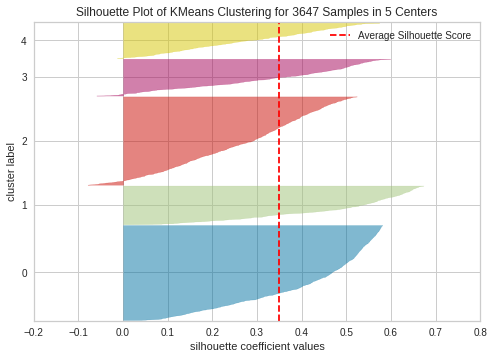

In [ ]:
# !pip install yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

model_kmeans = KMeans(n_clusters = 5, random_state = 9)
model_kmeans.fit_transform(X[['recency_lognorm', 'quantity_lognorm', 'revenue_lognorm']])

X['cluster'] = model_kmeans.labels_
X["cluster"] = X["cluster"].astype(str)

visualizer = SilhouetteVisualizer(model_kmeans, colors='yellowbrick')

visualizer.fit(X[['recency_lognorm', 'quantity_lognorm', 'revenue_lognorm']])        # Fit the data to the visualizer
visualizer.show()

hasil silhouette pun menunjukkan 5 cluster ini hanya terdapat sedikit data yang minus. Sehingga kita simpulkan bahwa 5 cluster adalah yang paling optimal. Sekarang kita tambahkan label cluster pada dataset

In [ ]:
product_rfm['cluster'] = model_kmeans.fit_predict(product_rfm[['recency_lognorm', 'quantity_lognorm', 'revenue_lognorm']])

product_rfm['cluster'] = product_rfm['cluster'].astype(int)

product_rfm

StockCode  recency  Quantity  revenue  recency_norm  quantity_norm  \
0        10002      236       823   699.55      0.630027       0.015160   
1        10080       19       291   114.41      0.048257       0.005348   
2        10120        6       192    40.32      0.013405       0.003523   
3       10123C      254         5     3.25      0.678284       0.000074   
4       10124A       34        16     6.72      0.088472       0.000277   
...        ...      ...       ...      ...           ...            ...   
3642    90214U        5        12     3.48      0.010724       0.000203   
3643    90214V        5        14     5.98      0.010724       0.000240   
3644    90214W        5        12     3.48      0.010724       0.000203   
3645    90214Y        4        61    18.65      0.008043       0.001107   
3646    90214Z        5        12     3.48      0.010724       0.000203   

      revenue_norm  recency_log  recency_lognorm  quantity_log  \
0         0.005332     5.463832         0.922282      6.712956   
1         0.000869     2.944439         0.497014      5.673323   
2         0.000304     1.791759         0.302445      5.257495   
3         0.000022     5.537334         0.934689      1.609438   
4         0.000048     3.526361         0.595241      2.772589   
...            ...          ...              ...           ...   
3642      0.000023     1.609438         0.271669      2.484907   
3643      0.000042     1.609438         0.271669      2.639057   
3644      0.000023     1.609438         0.271669      2.484907   
3645      0.000139     1.386294         0.234003      4.110874   
3646      0.000023     1.609438         0.271669      2.484907   

      quantity_lognorm  revenue_log  revenue_lognorm  cluster  
0             0.615819     6.550437         0.586333        3  
1             0.520447     4.739788         0.443215        4  
2             0.482301     3.696848         0.360778        2  
3             0.147643     1.178655         0.161733        1  
4             0.254346     1.905088         0.219153        4  
...                ...          ...              ...      ...  
3642          0.227955     1.247032         0.167138        4  
3643          0.242096     1.788421         0.209931        4  
3644          0.227955     1.247032         0.167138        4  
3645          0.377115     2.925846         0.299836        4  
3646          0.227955     1.247032         0.167138        4  

[3647 rows x 14 columns]

Selain itu kita tambahkan pula nilai centroid dari masing-masing cluster

In [ ]:
centroid = model_kmeans.cluster_centers_.tolist()
keys = [0,1,2,3,4]

centroid_df = pd.DataFrame.from_dict(dict(zip(keys, centroid))).T

cols = {'index': 'cluster',
        0: 'recency_centroid',
        1: 'quantity_centroid',
        2: 'revenue_centroid'}

centroid_df.reset_index(inplace = True)
centroid_df.rename(columns = cols, inplace = True)

centroid_df

cluster  recency_centroid  quantity_centroid  revenue_centroid
0        0          0.097803           0.706200          0.711615
1        1          0.895163           0.198947          0.306293
2        2          0.241581           0.527079          0.563571
3        3          0.756695           0.528982          0.558008
4        4          0.477196           0.286208          0.387451

In [ ]:
product_rfm = pd.merge(product_rfm, centroid_df, how = 'inner', left_on = 'cluster', right_on = 'cluster')
product_rfm

StockCode  recency  Quantity  revenue  recency_norm  quantity_norm  \
0        10002      236       823   699.55      0.630027       0.015160   
1        10133       94      2363  1134.79      0.249330       0.043562   
2       15044B       73       307   865.65      0.193029       0.005643   
3       15058B       23       115   866.25      0.058981       0.002102   
4       15058C       75       193   894.35      0.198391       0.003541   
...        ...      ...       ...      ...           ...            ...   
3642     85178        5      2316  2453.44      0.010724       0.042695   
3643    85184C        5      1519  2466.63      0.010724       0.027996   
3644    85199S        2      2227   943.13      0.002681       0.041053   
3645     85212        3      2427   702.47      0.005362       0.044742   
3646     90057        2      1008  1311.36      0.002681       0.018572   

      revenue_norm  recency_log  recency_lognorm  quantity_log  \
0         0.005332     5.463832         0.922282      6.712956   
1         0.008651     4.543295         0.766897      7.767687   
2         0.006599     4.290459         0.724219      5.726848   
3         0.006603     3.135494         0.529264      4.744932   
4         0.006817     4.317488         0.728782      5.262690   
...            ...          ...              ...           ...   
3642      0.018708     1.609438         0.271669      7.747597   
3643      0.018808     1.609438         0.271669      7.325808   
3644      0.007189     0.693147         0.117002      7.708411   
3645      0.005354     1.098612         0.185443      7.794411   
3646      0.009998     0.693147         0.117002      6.915723   

      quantity_lognorm  revenue_log  revenue_lognorm  cluster  \
0             0.615819     6.550437         0.586333        3   
1             0.712576     7.034203         0.624571        3   
2             0.525357     6.763481         0.603173        3   
3             0.435281     6.764174         0.603227        3   
4             0.482778     6.796097         0.605751        3   
...                ...          ...              ...      ...   
3642          0.710733     7.805246         0.685516        0   
3643          0.672039     7.810608         0.685940        0   
3644          0.707138     6.849204         0.609948        0   
3645          0.715027     6.554603         0.586662        0   
3646          0.634420     7.178820         0.636002        0   

      recency_centroid  quantity_centroid  revenue_centroid  
0             0.756695           0.528982          0.558008  
1             0.756695           0.528982          0.558008  
2             0.756695           0.528982          0.558008  
3             0.756695           0.528982          0.558008  
4             0.756695           0.528982          0.558008  
...                ...                ...               ...  
3642          0.097803           0.706200          0.711615  
3643          0.097803           0.706200          0.711615  
3644          0.097803           0.706200          0.711615  
3645          0.097803           0.706200          0.711615  
3646          0.097803           0.706200          0.711615  

[3647 rows x 17 columns]

In [ ]:
# product_rfm['cluster'].value_counts()
product_rfm['recency_centroid'].unique()[0]

0.7566952116518411

Kita sajikan hasil analisis kita ke dalam plot clustering

In [ ]:
px.scatter_3d(data_frame = product_rfm, x='recency', y='Quantity', z='revenue', color = 'cluster',
             title='3D Scatter plot for KMeans Clusters')

Sangat sulit kita representasikan jika menggunakan kolom tanpa scale sehingga kita buat plot dalam bentuk scaling juga

In [ ]:
px.scatter_3d(data_frame = product_rfm, x='recency_lognorm', y='quantity_lognorm', z='revenue_lognorm', color = 'cluster',
             title='3D Scatter plot for KMeans Clusters')

Selanjutnya kita buat pengelompokkan variabel-variabel RFM asli dari masing-masing produk berdasarkan cluster yang sudah kita buat

In [ ]:
# product_rfm.groupby('cluster', as_index = False).agg({'recency': ['mean'], 'Quantity': ['mean'], 'revenue': ['mean', 'count']})

rfm_group = product_rfm.groupby('cluster', as_index = False).agg(recency_min = ('recency', 'min'), recency_mean = ('recency', 'mean'), recency_max = ('recency', 'max'),
                                                                 quantity_min = ('Quantity', 'min'), quantity_mean = ('Quantity', 'mean'), quantity_max = ('Quantity', 'max'), 
                                                                 revenue_min = ('revenue', 'min'), revenue_mean = ('revenue', 'mean'), revenue_max = ('revenue', 'max'),
                                                                 count_rfm = ('revenue', 'count'))

rfm_group = rfm_group.sort_values(by = ['recency_min', 'recency_mean', 'recency_max', 'quantity_min', 'quantity_mean', 'quantity_max', 'revenue_min', 'revenue_mean', 'revenue_max'], ascending = [True, True, True, False, False, False, False, False, False])
rfm_group

cluster  recency_min  recency_mean  recency_max  quantity_min  \
0        0            1      2.033107           12           198   
2        2            1      5.401826           19            12   
4        4            2     21.473684           62             1   
3        3           20    119.479212          373            23   
1        1           39    223.433333          374             1   

   quantity_mean  quantity_max  revenue_min  revenue_mean  revenue_max  \
0    3479.025467         54223       245.10   5875.639431    131125.00   
2     499.590868          5219        11.05    811.457954     10890.15   
4      40.064073           291         0.95    116.264233      2745.00   
3     626.411379          6625        22.99   1111.750481     47027.55   
1      17.164583           108         0.42     39.022271       607.65   

   count_rfm  
0       1178  
2       1095  
4        437  
3        457  
1        480

**Result**



*   Cluster 0: Best Product

    Definition: Produk yang paling laris dan paling menghasilkan
    
    Action: Meningkatkan produksi dan ketersediaan produk

*   Cluster 2: Potential product

    Definition: Produk baru yang cukup laris dan cukup menghasilkan
    
    Action: Meningkatkan campaign produk

*   Cluster 4: At risk product

    Definition: Produk baru yang kurang diminati dan kurang menghasilkan
    
    Action: Melakukan survey ke customer tentang produk ini dan meningkatkan mutu ketertarikan dari produk ini

*   Cluster 3: Treasure product

    Definition: Produk lama yang cukup diminati dan cukup menghasilkan
    
    Action: Melakukan survey ke customer tentang produk ini serta memasarkan kembali produk ini

*   Cluster 1: Unsold product

    Definition: Produk yang sangat kurang laku dan sangat kurang menghasilkan
    
    Action: Melakukan survey ke customer tentang produk ini untuk pembelajaran pengembangan produk baru







In [ ]:
product_rfm = pd.merge(product_rfm, rfm_group, how = 'inner', left_on = 'cluster', right_on = 'cluster')
product_rfm

StockCode  recency  Quantity  revenue  recency_norm  quantity_norm  \
0        10002      236       823   699.55      0.630027       0.015160   
1        10133       94      2363  1134.79      0.249330       0.043562   
2       15044B       73       307   865.65      0.193029       0.005643   
3       15058B       23       115   866.25      0.058981       0.002102   
4       15058C       75       193   894.35      0.198391       0.003541   
...        ...      ...       ...      ...           ...            ...   
3642     85178        5      2316  2453.44      0.010724       0.042695   
3643    85184C        5      1519  2466.63      0.010724       0.027996   
3644    85199S        2      2227   943.13      0.002681       0.041053   
3645     85212        3      2427   702.47      0.005362       0.044742   
3646     90057        2      1008  1311.36      0.002681       0.018572   

      revenue_norm  recency_log  recency_lognorm  quantity_log  ...  \
0         0.005332     5.463832         0.922282      6.712956  ...   
1         0.008651     4.543295         0.766897      7.767687  ...   
2         0.006599     4.290459         0.724219      5.726848  ...   
3         0.006603     3.135494         0.529264      4.744932  ...   
4         0.006817     4.317488         0.728782      5.262690  ...   
...            ...          ...              ...           ...  ...   
3642      0.018708     1.609438         0.271669      7.747597  ...   
3643      0.018808     1.609438         0.271669      7.325808  ...   
3644      0.007189     0.693147         0.117002      7.708411  ...   
3645      0.005354     1.098612         0.185443      7.794411  ...   
3646      0.009998     0.693147         0.117002      6.915723  ...   

      recency_min  recency_mean  recency_max  quantity_min  quantity_mean  \
0              20    119.479212          373            23     626.411379   
1              20    119.479212          373            23     626.411379   
2              20    119.479212          373            23     626.411379   
3              20    119.479212          373            23     626.411379   
4              20    119.479212          373            23     626.411379   
...           ...           ...          ...           ...            ...   
3642            1      2.033107           12           198    3479.025467   
3643            1      2.033107           12           198    3479.025467   
3644            1      2.033107           12           198    3479.025467   
3645            1      2.033107           12           198    3479.025467   
3646            1      2.033107           12           198    3479.025467   

      quantity_max  revenue_min  revenue_mean  revenue_max  count_rfm  
0             6625        22.99   1111.750481     47027.55        457  
1             6625        22.99   1111.750481     47027.55        457  
2             6625        22.99   1111.750481     47027.55        457  
3             6625        22.99   1111.750481     47027.55        457  
4             6625        22.99   1111.750481     47027.55        457  
...            ...          ...           ...          ...        ...  
3642         54223       245.10   5875.639431    131125.00       1178  
3643         54223       245.10   5875.639431    131125.00       1178  
3644         54223       245.10   5875.639431    131125.00       1178  
3645         54223       245.10   5875.639431    131125.00       1178  
3646         54223       245.10   5875.639431    131125.00       1178  

[3647 rows x 27 columns]

**Save data to csv**

In [ ]:
from google.colab import drive
drive.mount('drive')

clean_data.to_csv('clean_ecommerce.csv', sep=';', encoding='utf-8')

!cp clean_ecommerce.csv "drive/My Drive/Dataset"

product_rfm.to_csv('product_rfm_result.csv', sep=';', encoding='utf-8')

!cp product_rfm_result.csv "drive/My Drive/Dataset"

Mounted at drive


### **Remarks**

Kita berhasil membuat cluster produk dari dataset dan memberikan rekomendasi action untuk stakeholder dalam strategi bisnis ke depan secara data-driven.

Pertemuan berikutnya kita akan membahas profiling pelanggan yang tujuannya para pelanggan ini mendapatkan campaign marketing yang personalized.